In [1]:
import os # need to happen before loading numpy
os.environ["OMP_NUM_THREADS"] = "8" # export OMP_NUM_THREADS=8
os.environ["OPENBLAS_NUM_THREADS"] = "8" # export OPENBLAS_NUM_THREADS=8
os.environ["MKL_NUM_THREADS"] = "8" # export MKL_NUM_THREADS=8
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" # export VECLIB_MAXIMUM_THREADS=8
os.environ["NUMEXPR_NUM_THREADS"] = "8" # export NUMEXPR_NUM_THREADS=8

In [2]:
import sys
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f, create_linear_f
from on_manifold import OnManifoldExplainer, IndExplainer

if '../shap' not in sys.path:
    sys.path = ['../shap'] + sys.path
    import shap
    
import tqdm
from numba import jit
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
import copy
import seaborn as sns
import scipy as sp
import scipy.cluster
import matplotlib.pyplot as pl
from graphviz import Digraph
from collections import defaultdict
from sklearn.linear_model import LogisticRegression, LinearRegression

# The chain experiment

![Chain Experiment](../figures/chain_illustration.png)

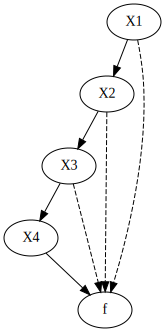

In [3]:
dot = Digraph()
dot.node('1', 'X1')
dot.node('2', 'X2')
dot.node('3', 'X3')
dot.node('4', 'X4')
dot.node('5', 'f')

dot.edges(['12','23', '34', '45'])
dot.edge('1', '5', style='dashed')
dot.edge('2', '5', style='dashed')
dot.edge('3', '5', style='dashed')

dot

In [4]:
import itertools
list(itertools.permutations([1,2,3]))

[(1, 2, 3), (1, 3, 2), (2, 1, 3), (2, 3, 1), (3, 1, 2), (3, 2, 1)]

In [5]:
n = 1000
x1 = np.random.randn(n)
x4 = x3 = x2 = x1
 
X = pd.DataFrame.from_dict({'X1': x1, 'X2': x2, 'X3': x3, 'X4': x4}).loc[:, ['X1', 'X2', 'X3', 'X4']]
f = lambda x: x[:, 3] # assume x 2d
f_d = pd.DataFrame.from_dict({'f': list(f(np.array(X)))})
pd.concat((X, f_d), 1)

,X1,X2,X3,X4,f
0,0.608476,0.608476,0.608476,0.608476,0.608476
1,-1.210795,-1.210795,-1.210795,-1.210795,-1.210795
2,-0.893183,-0.893183,-0.893183,-0.893183,-0.893183
3,-0.281542,-0.281542,-0.281542,-0.281542,-0.281542
4,0.913184,0.913184,0.913184,0.913184,0.913184
...,...,...,...,...,...
995,-0.257455,-0.257455,-0.257455,-0.257455,-0.257455
996,-0.629589,-0.629589,-0.629589,-0.629589,-0.629589
997,-0.581493,-0.581493,-0.581493,-0.581493,-0.581493
998,-0.300864,-0.300864,-0.300864,-0.300864,-0.300864


In [6]:
n_explain = 10
explainer = OnManifoldExplainer(f, X, nruns=1000, sigma_sq=1e-10)
cf_on_manifold = explainer.shap_values(X[:n_explain])

100%|██████████| 10/10 [00:00<00:00, 27.67it/s]


In [7]:
explainer = IndExplainer(f, X, nruns=100)
cf_ind = explainer.shap_values(X[:n_explain])

100%|██████████| 100/100 [00:00<00:00, 4965.38it/s]


In [8]:
n_explain = 10
explainer = OnManifoldExplainer(f, X, nruns=100, sigma_sq=1e-10, orderings=[[0, 1, 2, 3]])
cf_asv = explainer.shap_values(X[:n_explain])

100%|██████████| 10/10 [00:00<00:00, 27.77it/s]


In [22]:
causal_links = CausalLinks()
target_name = 'f'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, lambda *args: f(np.vstack(args).T))
causal_links.add_causes_effects('X1', 'X2', lambda x: x)
causal_links.add_causes_effects('X2', 'X3', lambda x: x)
causal_links.add_causes_effects('X3', 'X4', lambda x: x)
causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, target_name=target_name)

cf_flow = GraphExplainer(causal_graph, X, nruns=100).shap_values(X[:100], rankdir='LR')

0it [00:00, ?it/s]
bruteforce sampling: 100%|██████████| 100/100 [00:00<00:00, 1978.47it/s]


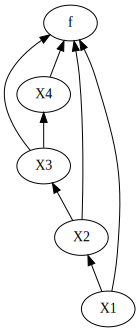

In [10]:
causal_graph.draw()

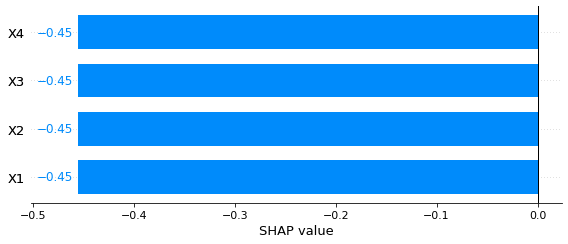

In [11]:
sample_ind = 1
cf_on_manifold.draw(sample_ind, show=False)
plt.tight_layout()
plt.savefig('figures/chain_on_manifold.png')
plt.show()

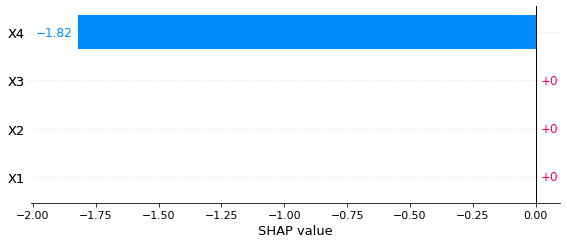

In [12]:
cf_ind.draw(sample_ind, show=False)
plt.tight_layout()
plt.savefig('figures/chain_independent.png')
plt.show()

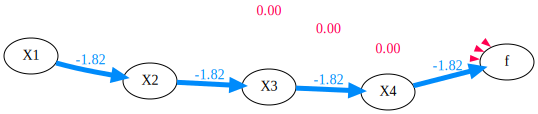

In [23]:
g = cf_flow.draw(sample_ind, show_fg_val=False)
save_graph(g, f'figures/chain_flow.png')

ASV


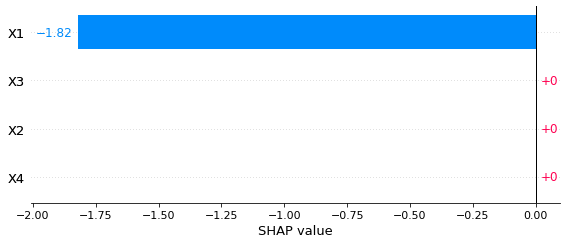

In [14]:
# asv
print('ASV')
def prepare_bar_asv(target_node, edge_credit, sample_ind, graph):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    
    for node in graph: # add internal nodes
        if node.is_target_node or len(node.args) == 0: continue
        b.values.append(0)
        b.input_names.append(node.name)
        
    b.data = None #np.arange(len(b.input_names))
    b.transform_history = []
    return b

target_node = [i for i in cf_flow.graph if i.is_target_node][0]
edge_credit = cf_flow.get_asv_edge_credit(sample_ind)

b = prepare_bar_asv(target_node, edge_credit, sample_ind, cf_flow.graph)
shap.plots.bar(b, max_display=None, show=False)
plt.tight_layout()
plt.savefig('figures/chain_asv.png')
plt.show()

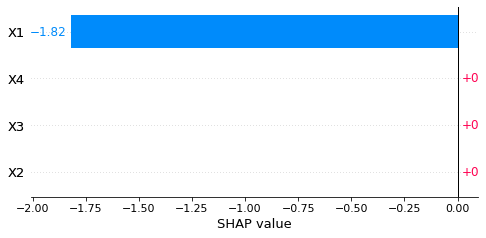

In [15]:
# alternative implementation of ASV
cf_asv.draw(sample_ind)

In [16]:
fg = X.iloc[sample_ind]
bg = X.iloc[0]
fg - bg

X1   -1.81927
X2   -1.81927
X3   -1.81927
X4   -1.81927
dtype: float64

In [18]:
latex_dict = {}

# asv
def prepare_bar_asv(target_node, edge_credit, sample_ind):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    b.data = None #np.arange(len(b.input_names))
    b.transform_history = []
    return b

target_node = [i for i in cf_flow.graph if i.is_target_node][0]
edge_credit = cf_flow.get_asv_edge_credit(sample_ind)
b = prepare_bar_asv(target_node, edge_credit, sample_ind)
latex_dict['asv'] = {k:v for k,v in zip(map(lambda n: n[:-6] if n[-5:] == 'noise' else n,
                                            b.input_names), 
                                        b.values)}

# shap
def prepare_on_ind(cf, sample_ind):
    class D(): pass
    b.input_names = cf.input_names
    b.values = cf.values[sample_ind]
    return b

b = prepare_on_ind(cf_ind, sample_ind)
latex_dict['ind'] = {k:v for k,v in zip(b.input_names, b.values)}

# on manifold
def prepare_on_manifold(cf, sample_ind):
    class D(): pass
    b.input_names = cf.input_names
    b.values = cf.values[sample_ind]
    return b

b = prepare_on_manifold(cf_on_manifold, sample_ind)
latex_dict['manifold'] = {k:v for k,v in zip(b.input_names, b.values)}

# resulting data frame
df = pd.DataFrame.from_dict(latex_dict).loc[:, ['ind', 'manifold', 'asv']]
df.loc[:, 'asv'] = df.loc[:, 'asv'].fillna(0)
print(df.round(2).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &   ind &  manifold &   asv \\
\midrule
X1 &  0.00 &     -0.45 & -1.82 \\
X2 &  0.00 &     -0.45 &  0.00 \\
X3 &  0.00 &     -0.45 &  0.00 \\
X4 & -1.82 &     -0.45 &  0.00 \\
\bottomrule
\end{tabular}



In [19]:
colors = np.array(df.fillna(0))

# normalize each column by the largest absolute value
for i in range(colors.shape[1]):
    colors[:, i] /= np.abs(colors[:, i]).max()
    colors[:, i] *= 100
colors = colors.astype(np.int)

# sort index by its abs score across columns
feature_order = np.abs(colors).sum(1).argsort()[::-1]

In [20]:
table = "\\begin{tabular}{lrrr}\n\\toprule\n"
table += r"{} & Independent & On-manifold & ASV\\"
table += "\n\\midrule\n"
for i in feature_order:
    row = []
    feature_name = df.iloc[i].name
    row.append(feature_name)
    for j in range(colors.shape[1]):
        v = df.iloc[i, j].round(2)
        c = "blue" if colors[i, j] < 0 else "red"
        c = f"\\cellcolor{{{c}!{np.abs(colors[i,j])}}}"
        row.append(f"{c} {v}")
    table += r" & ".join(row)
    table += "\\\\\n"
table += "\\bottomrule\n\\end{tabular}"
print(table)

\begin{tabular}{lrrr}
\toprule
{} & Independent & On-manifold & ASV\\
\midrule
X4 & \cellcolor{blue!100} -1.82 & \cellcolor{blue!100} -0.45 & \cellcolor{red!0} 0.0\\
X1 & \cellcolor{red!0} 0.0 & \cellcolor{blue!100} -0.45 & \cellcolor{blue!100} -1.82\\
X3 & \cellcolor{red!0} 0.0 & \cellcolor{blue!100} -0.45 & \cellcolor{red!0} 0.0\\
X2 & \cellcolor{red!0} 0.0 & \cellcolor{blue!100} -0.45 & \cellcolor{red!0} 0.0\\
\bottomrule
\end{tabular}


# Linear synthetic experiment: explore diverse set of graphs (later can explore changing graph properties to see how that affect the interpretation)

10 nodes


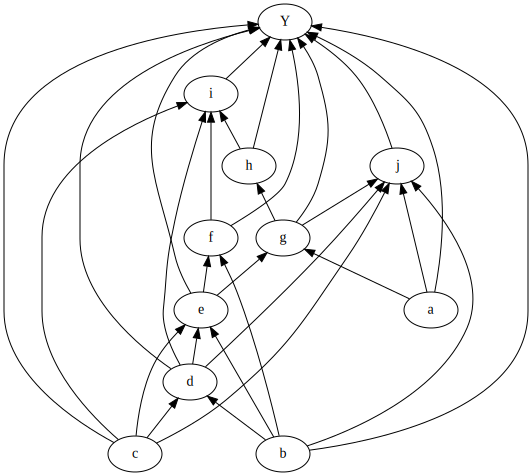

In [64]:
def build_random_linear_graph(n_nodes=10):
    nodes = []
    name = 'a'
    for _ in range(n_nodes):
        len_args = 0 if len(nodes) == 0 else np.random.choice(len(nodes))
        args = [nodes[i] for i in np.random.choice(len(nodes), len_args, replace=False)]
        weights, b = np.random.randn(len_args), np.random.randn() # linear model weight and bias
        node = Node(name, lambda *args: sum([w * arg for w, arg in zip(weights, args)]) + b, args)
        name = chr(ord(name) + 1)
        nodes.append(node)

    print(len(nodes), "nodes")
    args = nodes # all nodes are input to Y
    weights, b = np.random.randn(len(args)), np.random.randn()
    n_irrelevant_features = 3 # np.random.choice(len(nodes)) # todo: use random later for more graphs
    if n_irrelevant_features != 0:
        drop_features = np.random.choice(len(nodes), n_irrelevant_features, replace=False)
        weights[drop_features] = 0
    
    target_node = Node('Y', lambda *args: sum([w * arg for w, arg in zip(weights, args)]) + b, 
                       args, is_target_node=True)
    nodes.append(target_node)
    
    graph = Graph(nodes)
    return graph

graph = build_random_linear_graph()
graph.draw()

In [65]:
# build a linear dataset according to the graph
n = 1000
sources = get_source_nodes(graph)
target_node = [node for node in graph if node.is_target_node][0]
d = dict((node.name, np.random.randn(n)) for node in sources)
eval_graph(graph, d)

X_linear = pd.DataFrame.from_dict({node.name:node.val for node in graph if not node.is_target_node}).loc[:,[node.name for node in target_node.args]]
f = lambda x: target_node.f(*[x[:,i] for i in range(x.shape[1])])
f_d = pd.DataFrame.from_dict({'Y': list(f(np.array(X_linear)))})
pd.concat((X_linear, f_d), 1)

,a,b,c,d,e,f,g,h,i,j,Y
0,1.047742,0.591841,0.906482,1.806325,0.671647,1.481315,1.952240,2.886545,-0.742197,3.603237,2.332641
1,1.595002,0.107137,-0.799641,0.043979,0.016353,0.980639,2.517534,3.470467,-0.708107,4.162088,5.112564
2,-1.702839,0.395714,-0.911030,-0.071080,-0.026430,1.278726,-0.888982,-0.048305,2.806173,0.440525,-6.022775
3,1.324015,1.106718,0.191602,1.067887,0.397073,2.013160,2.237617,3.181326,-0.006509,3.436505,2.353460
4,0.834991,-0.535475,-1.952331,-1.146695,-0.426376,0.316851,1.732478,2.659541,0.053120,3.532182,3.919772
...,...,...,...,...,...,...,...,...,...,...,...
995,-0.497060,-1.577824,0.368479,1.250594,0.465009,-0.759847,0.356532,1.238253,-1.250078,3.213944,1.315272
996,-0.030277,0.398732,0.777710,1.673310,0.622188,1.281843,0.838697,1.736307,0.157894,2.549432,-0.781063
997,-0.858066,-1.373742,-0.521171,0.331627,0.123309,-0.549040,-0.016371,0.853061,-0.130140,2.528713,-0.141610
998,0.303427,1.165932,-0.049091,0.819262,0.304627,2.074325,1.183397,2.092366,1.178494,2.263858,-1.021101


In [66]:
n_explain = 100
cf_flow_linear = GraphExplainer(graph, X_linear, nruns=1).shap_values(X_linear[:n_explain])

bruteforce sampling: 100%|██████████| 1/1 [00:00<00:00, 96.66it/s]


In [67]:
explainer = OnManifoldExplainer(f, X_linear, nruns=10, sigma_sq=0.1) 
cf_on_manifold_linear = explainer.shap_values(X_linear[:n_explain])

100%|██████████| 100/100 [00:05<00:00, 18.11it/s]


In [68]:
explainer = IndExplainer(f, X_linear, nruns=100)
cf_ind_linear = explainer.shap_values(X_linear[:n_explain])

100%|██████████| 100/100 [00:00<00:00, 860.18it/s]


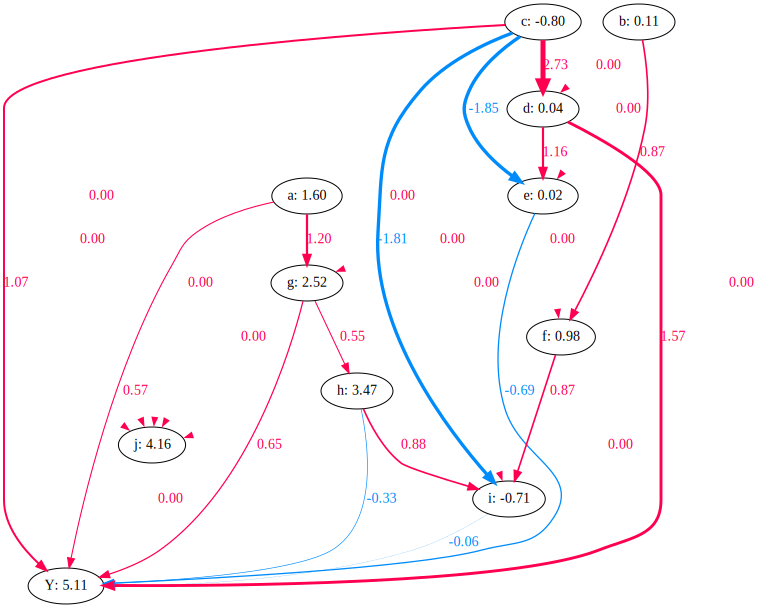

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f2602319360>>

In [69]:
cf_flow_linear.draw(sample_ind)

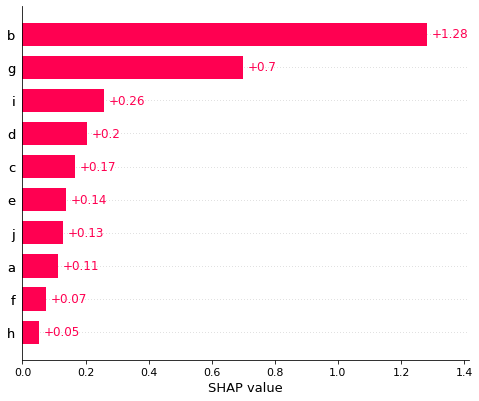

In [43]:
cf_on_manifold_linear.draw(sample_ind)

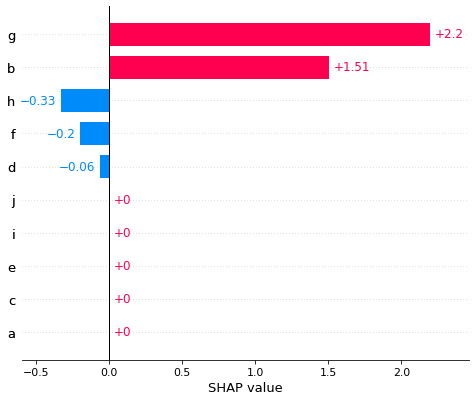

In [44]:
cf_ind_linear.draw(sample_ind)

ASV


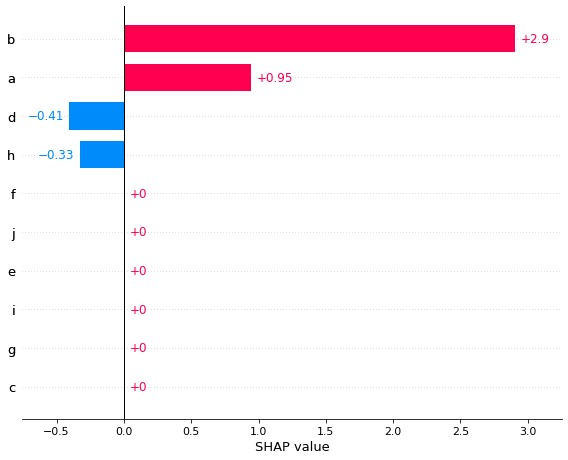

In [45]:
# asv
print('ASV')
def prepare_bar_asv(target_node, edge_credit, sample_ind, graph):
    '''prepare into barchart format for shap'''
    class D():
        pass

    b = D()
    b.input_names = [i for i in edge_credit.keys() if hasattr(i, 'is_target_node')]
    b.values = [edge_credit[i][target_node] for i in b.input_names]
    b.input_names = list(map(str, b.input_names))
    
    for node in graph: # add internal nodes
        if node.is_target_node or len(node.args) == 0: continue
        b.values.append(0)
        b.input_names.append(node.name)
        
    b.data = None #np.arange(len(b.input_names))
    b.transform_history = []
    return b

target_node = [i for i in cf_flow_linear.graph if i.is_target_node][0]
edge_credit = cf_flow_linear.get_asv_edge_credit(sample_ind)

b = prepare_bar_asv(target_node, edge_credit, sample_ind, cf_flow_linear.graph)
shap.plots.bar(b, max_display=None, show=False)
plt.tight_layout()
plt.show()

In [46]:
intervention_on = 'i'
sources = get_source_nodes(graph)
d = dict((node.name, X_linear.loc[0, node.name]) for node in sources) # background
before = eval_graph(graph, d)
print(f'output before intervening on {intervention_on}:', before)

d.update({intervention_on: X_linear.loc[sample_ind, intervention_on]}) # foreground
after = eval_graph(graph, d)
print(f'output after intervening on {intervention_on}:', after)

print('difference is', after - before)

output before intervening on i: [0.7752985]
output after intervening on i: [0.7752985]
difference is [0.]


Y    3.167116
dtype: float64

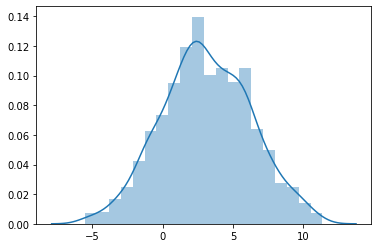

In [47]:
sns.distplot(f_d)
np.std(f_d)

## direct effect

In [126]:
def get_direct_effect_ground_truth(graph, X):
    gt = {}
    for n in graph:
        if n.is_target_node: continue

        intervention_on = n.name
        
        d = dict((node.name, np.array(X.loc[0, node.name])) for node in graph if not node.is_target_node) # background
        before = eval_graph(graph, d)

        d.update({intervention_on: np.array(X.loc[1:n_explain-1, intervention_on])}) # foreground
        after = eval_graph(graph, d)

        gt[intervention_on] = after - before
    return gt

def get_effect_ind(cf):
    d = defaultdict(int)
    d.update({k:v[1:n_explain] for k, v in zip(cf.input_names, cf.values.T)})
    return d

def get_effect_manifold(cf):
    d = defaultdict(int)
    d.update({k:v[1:n_explain] for k, v in zip(cf.input_names, cf.values.T)})
    return d

def get_direct_effect_flow(cf):
    d = defaultdict(int)
    ec = cf.edge_credit
    for node1, v_dict in ec.items():
        for node2, v in v_dict.items():
            if node2.is_target_node:
                d[node1.name] = v[1:n_explain]

    return d

def get_effect_asv(cf):
    d = defaultdict(int)
    ec = cf.get_asv_edge_credit(aggregate=False)

    for node1, v_dict in ec.items():
        for node2, v in v_dict.items():
            if node2.is_target_node:
                d[node1.name] = v[1:n_explain]

    return d

def get_error(gt, theta, allowed_nodes=None):
    diff = []
    for k in gt:
        if allowed_nodes is not None and k not in [node.name for node in allowed_nodes]:
            continue
        diff = np.hstack([diff, gt[k] - theta[k]])
    return diff

gt = get_direct_effect_ground_truth(graph, X_linear)
theta_ind = get_effect_ind(cf_ind_linear)
theta_manifold = get_effect_manifold(cf_on_manifold_linear)
theta_asv = get_effect_asv(cf_flow_linear)
theta_flow = get_direct_effect_flow(cf_flow_linear)

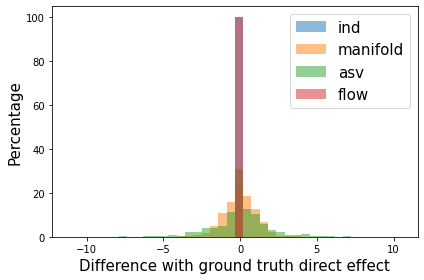

In [127]:
errors = {
    'ind': get_error(gt, theta_ind),
    'manifold': get_error(gt, theta_manifold),
    'asv': get_error(gt, theta_asv),
    'flow': get_error(gt, theta_flow)
}

bins=np.histogram(np.hstack(list(errors.values())), bins=40)[1] #get the bin edges
for k, v in errors.items():
    plt.hist(v, bins, label=k, alpha=0.5, weights=np.zeros_like(v) + 100. / v.size)

plt.legend(fontsize=15)
plt.xlabel('Difference with ground truth direct effect', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.tight_layout()
plt.savefig('figures/synthetic_direct_error.png')
plt.show()

Can mislead to about 4 times the standard deviation!

## indirect effect

In [128]:
def get_indirect_effect_ground_truth(graph, X):
    gt = {}
    for n in graph:
        if n.is_target_node: continue

        intervention_on = n.name
        sources = get_source_nodes(graph)

        d = dict((node.name, np.array(X.loc[0, node.name])) for node in sources) # background
        before = eval_graph(graph, d)

        d.update({intervention_on: np.array(X.loc[1:n_explain-1, intervention_on])}) # foreground
        after = eval_graph(graph, d)

        gt[intervention_on] = after - before
    return gt

def get_indirect_effect_flow(cf):
    d = defaultdict(int)
    ec = cf.edge_credit
    for node1, v_dict in ec.items():
        for node2, v in v_dict.items():
            d[node1.name] += v[1:n_explain]

    return d

gt_indirect = get_indirect_effect_ground_truth(graph, X_linear)
theta_flow_indirect = get_indirect_effect_flow(cf_flow_linear)

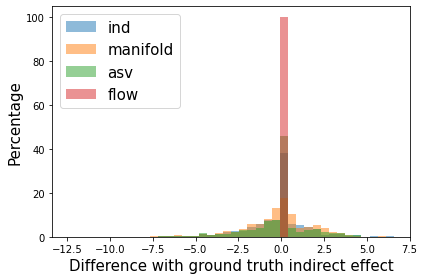

In [129]:
errors = {
    'ind': get_error(gt_indirect, theta_ind),
    'manifold': get_error(gt_indirect, theta_manifold),
    'asv': get_error(gt_indirect, theta_asv),
    'flow': get_error(gt_indirect, theta_flow_indirect)
}

bins=np.histogram(np.hstack(list(errors.values())), bins=40)[1] #get the bin edges
for k, v in errors.items():
    plt.hist(v, bins, label=k, alpha=0.5, weights=np.zeros_like(v) + 100. / v.size)

plt.legend(fontsize=15)
plt.xlabel('Difference with ground truth indirect effect', fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.tight_layout()
plt.savefig('figures/synthetic_indirect_error.png')
plt.show()

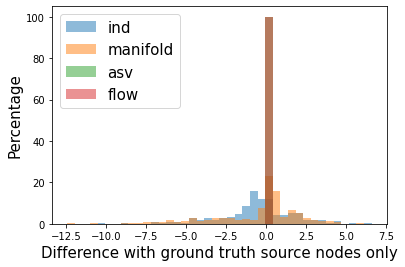

In [130]:
sources = get_source_nodes(graph)
errors = {
    'ind': get_error(gt_indirect, theta_ind, sources),
    'manifold': get_error(gt_indirect, theta_manifold, sources),
    'asv': get_error(gt_indirect, theta_asv, sources),
    'flow': get_error(gt_indirect, theta_flow_indirect, sources)
}

bins=np.histogram(np.hstack(list(errors.values())), bins=40)[1] #get the bin edges
for k, v in errors.items():
    plt.hist(v, bins, label=k, alpha=0.5, weights=np.zeros_like(v) + 100. / v.size)

plt.legend(fontsize=15)
plt.ylabel('Percentage', fontsize=15)
plt.xlabel('Difference with ground truth source nodes only', fontsize=15)
plt.show()